# Week 4 Mini Project: RNN Disaster Tweets Classification

By: Jaeyoung Oh

Repo: https://github.com/BlueJayVRStudio/CSCA5642_Week4

## Problem Statement

The objective of this week's mini project is to classify the context of Tweets. It is a simple binary classification between whether it is about real disasters or not. The set of data consists of a training set and a test set. The test set is reserved only for submission and not validation. The training set consists of 7613 hand-classified data points each composed of ID, keyword, location, body of text and target label. We will first explore keyword, location and text body to identify potential input columns and then perform necessary preprocessing steps on the selected input.

### Import Modules

In [16]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS']='ignore'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

Num GPUs Available: 1


## EDA

In [17]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [20]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


ID has no special meaning, so we can easily drop ID from the dataset. Additionally, there are too many null values in keyword and location. Keyword is selected word from the text so it is redudant information. Although location might provide some special context, there are too many null values and does not contain too much meaning. Therefore, we really only need to consider the text bodies as our input column. 

Now we will do some basic NLP preprocessing. *Here are some considerations*:
1. Most NLP tasks favor removing stop words and porter stemming, but for complex context dependent tasks like identifying real disaster in a tweet, preservation of stop words and suffixes may be quintessential especially taking into account the fact that RNN's can discern sequential/temporal patterns.
2. Because RNN learns sequential information, we have to use word tokens as opposed to vectors. We may also use a pretrained word embedding such as Word2Vec.
3. URL's don't provide enough contextual clues and unnecessarily increase complexity. Thus, we can easily decide to remove URL's.
4. For similar reason to removing URL's we can convert all texts to lowercase.

In [21]:
import re

def clean_text(text):
    # remove url's (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # convert to lowercase
    text = text.lower()
    return text

# try removing stopwords and suffixes as well
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text_V1(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.lower()
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)
    

In [22]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [23]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


*Next we look at class distribution to make sure there isn't too much class imbalance*:

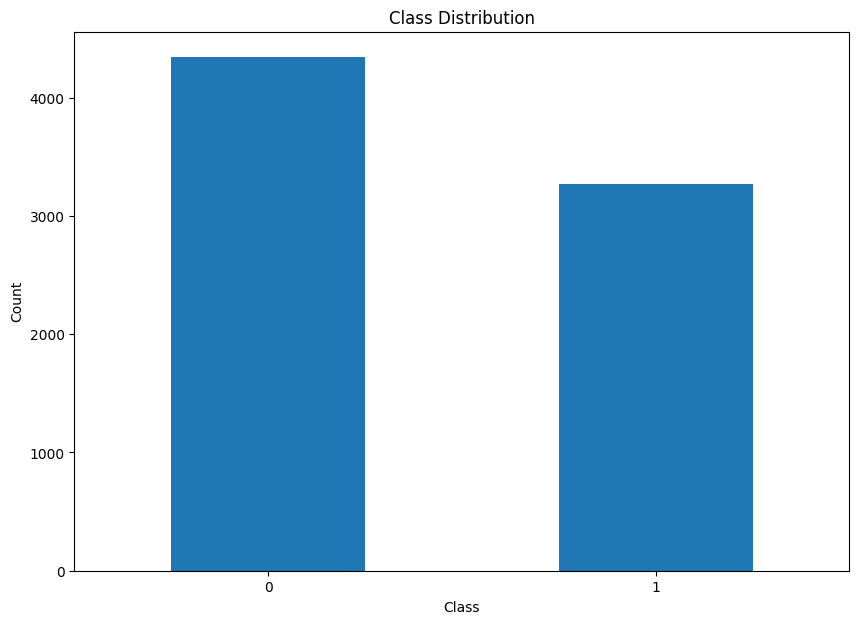

In [24]:
def plot_class_distribution(labels):
    class_counts = labels.value_counts()
    
    plt.figure(figsize=(10, 7))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

plot_class_distribution(train_df['target'])

### Prepare Embedding Matrix (using word2vec)

In [25]:
word2vec = KeyedVectors.load_word2vec_format('./embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [26]:
# maximum number of words in a text
max_sequence_length = 50  
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(train_df['text'])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')

In [27]:
# test set for submission
sequences_test = tokenizer.texts_to_sequences(test_df['text'])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

In [28]:
embedding_dim = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

# embedding_matrix

### Train-Validation Splits

In [29]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences_train, train_df['target'], test_size=0.2, random_state=0)

### EDA Conclusion

For this EDA, we first assessed that our input will consist only of the text column, as the keyword and the location columns do not provide meaningful context and contain numerous null values in an already sparse dataset. Then we determined that we will only remove URL's and convert the text to lowercase. We will refrain from removing the stop words and suffixes, as RNN architectures will be able to make use of contextual clues provided by stopwords and suffixes. Furthermore, we also confirmed that the class labels are fairly balanced and no further balance is needed. Lastly, we tokenized our training, validation and test data and created a word embedding matrix to be used as an enhancement for our RNN models.

## Model Building

### accuracy plot function

In [31]:
def plot_accuracy(hist, name):
    hist_train = hist.history['accuracy']
    hist_val = hist.history['val_accuracy']

    plt.figure(figsize=(11, 7))

    plt.plot(range(len(hist_train)), hist_train, marker='o', label = 'accuracy, training')
    plt.plot(range(len(hist_train)), hist_val, marker='o', label = 'accuracy, validation')
    
    plt.xticks(range(len(hist_train)), range(len(hist_train)), rotation=45)
    
    plt.legend() 
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(name)
    plt.grid(True)
    plt.show()

### GRU without Hyperparameter Tuning

In [39]:
# build GRU model
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),

    GRU(32, return_sequences=False, trainable=True),
    # Dropout(0.2),
    Dense(128, activation='relu', trainable=True),
    # Dropout(0.2),
    Dense(1, activation='sigmoid', trainable=True)
])

model.build()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-08)

# compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           5428200   
                                                                 
 gru_2 (GRU)                 (None, 32)                32064     
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5464617 (20.85 MB)
Trainable params: 36417 (142.25 KB)
Non-trainable params: 5428200 (20.71 MB)
_________________________________________________________________


In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
191/191 [==============================] - 4s 16ms/step - loss: 0.6848 - accuracy: 0.5658 - val_loss: 0.6797 - val_accuracy: 0.5817
Epoch 2/100
191/191 [==============================] - 2s 13ms/step - loss: 0.6717 - accuracy: 0.5846 - val_loss: 0.6343 - val_accuracy: 0.7262
Epoch 3/100
191/191 [==============================] - 2s 13ms/step - loss: 0.5188 - accuracy: 0.7685 - val_loss: 0.4822 - val_accuracy: 0.7814
Epoch 4/100
191/191 [==============================] - 3s 13ms/step - loss: 0.4359 - accuracy: 0.8151 - val_loss: 0.4436 - val_accuracy: 0.8004
Epoch 5/100
191/191 [==============================] - 2s 13ms/step - loss: 0.4157 - accuracy: 0.8294 - val_loss: 0.4473 - val_accuracy: 0.8030
Epoch 6/100
191/191 [==============================] - 2s 13ms/step - loss: 0.4028 - accuracy: 0.8332 - val_loss: 0.4308 - val_accuracy: 0.8089
Epoch 7/100
191/191 [==============================] - 2s 12ms/step - loss: 0.3838 - accuracy: 0.8438 - val_loss: 0.4617 - val_accuracy:

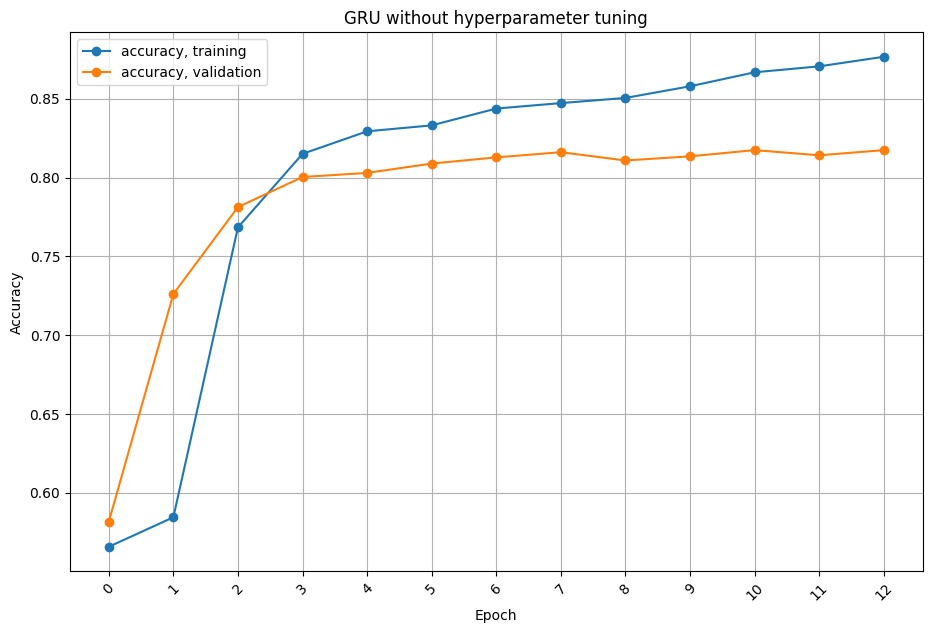

In [41]:
plot_accuracy(history, "GRU without hyperparameter tuning")

In [42]:
# save submission
y_test_pred = model.predict(padded_sequences_test)

102/102 [==============================] - 1s 6ms/step


In [43]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = (y_test_pred > 0.5).astype(int)

submission_df.to_csv("./submissions/GRU_no_tuning.csv", index=False)

### LSTM without Hyperparameter Tuning

In [44]:
# build LSTM model
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),

    LSTM(32, return_sequences=False, trainable=True),
    # Dropout(0.2),
    Dense(128, activation='relu', trainable=True),
    # Dropout(0.2),
    Dense(1, activation='sigmoid', trainable=True)
])

model.build()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-08)

# compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 300)           5428200   
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5475177 (20.89 MB)
Trainable params: 46977 (183.50 KB)
Non-trainable params: 5428200 (20.71 MB)
_________________________________________________________________


In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
191/191 [==============================] - 5s 16ms/step - loss: 0.5497 - accuracy: 0.7202 - val_loss: 0.4616 - val_accuracy: 0.7912
Epoch 2/100
191/191 [==============================] - 2s 12ms/step - loss: 0.4332 - accuracy: 0.8146 - val_loss: 0.4410 - val_accuracy: 0.8004
Epoch 3/100
191/191 [==============================] - 2s 12ms/step - loss: 0.4095 - accuracy: 0.8292 - val_loss: 0.4650 - val_accuracy: 0.8070
Epoch 4/100
191/191 [==============================] - 3s 13ms/step - loss: 0.3945 - accuracy: 0.8337 - val_loss: 0.4535 - val_accuracy: 0.8024
Epoch 5/100
191/191 [==============================] - 3s 14ms/step - loss: 0.3862 - accuracy: 0.8355 - val_loss: 0.4564 - val_accuracy: 0.7958
Epoch 6/100
191/191 [==============================] - 3s 13ms/step - loss: 0.3757 - accuracy: 0.8452 - val_loss: 0.4609 - val_accuracy: 0.7997
Epoch 7/100
191/191 [==============================] - 3s 13ms/step - loss: 0.3710 - accuracy: 0.8488 - val_loss: 0.4466 - val_accuracy:

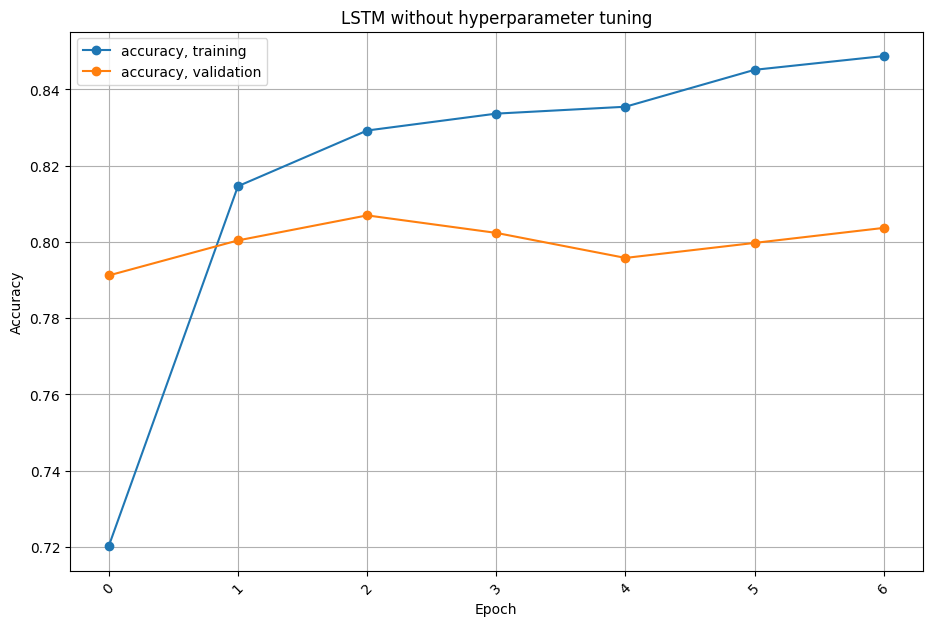

In [46]:
plot_accuracy(history, "LSTM without hyperparameter tuning")

In [47]:
# save submission
y_test_pred = model.predict(padded_sequences_test)

102/102 [==============================] - 1s 5ms/step


In [48]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = (y_test_pred > 0.5).astype(int)

submission_df.to_csv("./submissions/LSTM_no_tuning.csv", index=False)

### LSTM with Hyperparameter Tuning

In [49]:
# build LSTM model
model = Sequential([
    Input(shape=(max_sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),

    LSTM(16, return_sequences=False, trainable=True),
    Dropout(0.2),
    Dense(128, activation='relu', trainable=True),
    Dropout(0.2),
    Dense(1, activation='sigmoid', trainable=True)
])

model.build()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08)

# compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 300)           5428200   
                                                                 
 lstm_1 (LSTM)               (None, 16)                20288     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 128)               2176      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5450793 (20.79 MB)
Trainable params: 225

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping], 
                    verbose=1)

Epoch 1/100
191/191 [==============================] - 5s 16ms/step - loss: 0.6905 - accuracy: 0.5657 - val_loss: 0.6844 - val_accuracy: 0.5817
Epoch 2/100
191/191 [==============================] - 3s 15ms/step - loss: 0.6452 - accuracy: 0.6003 - val_loss: 0.5706 - val_accuracy: 0.7479
Epoch 3/100
191/191 [==============================] - 3s 14ms/step - loss: 0.5513 - accuracy: 0.7788 - val_loss: 0.5205 - val_accuracy: 0.7761
Epoch 4/100
191/191 [==============================] - 3s 14ms/step - loss: 0.4976 - accuracy: 0.7885 - val_loss: 0.4929 - val_accuracy: 0.7807
Epoch 5/100
191/191 [==============================] - 3s 14ms/step - loss: 0.4695 - accuracy: 0.8020 - val_loss: 0.4774 - val_accuracy: 0.7919
Epoch 6/100
191/191 [==============================] - 3s 14ms/step - loss: 0.4510 - accuracy: 0.8110 - val_loss: 0.4692 - val_accuracy: 0.7905
Epoch 7/100
191/191 [==============================] - 3s 14ms/step - loss: 0.4381 - accuracy: 0.8176 - val_loss: 0.4634 - val_accuracy:

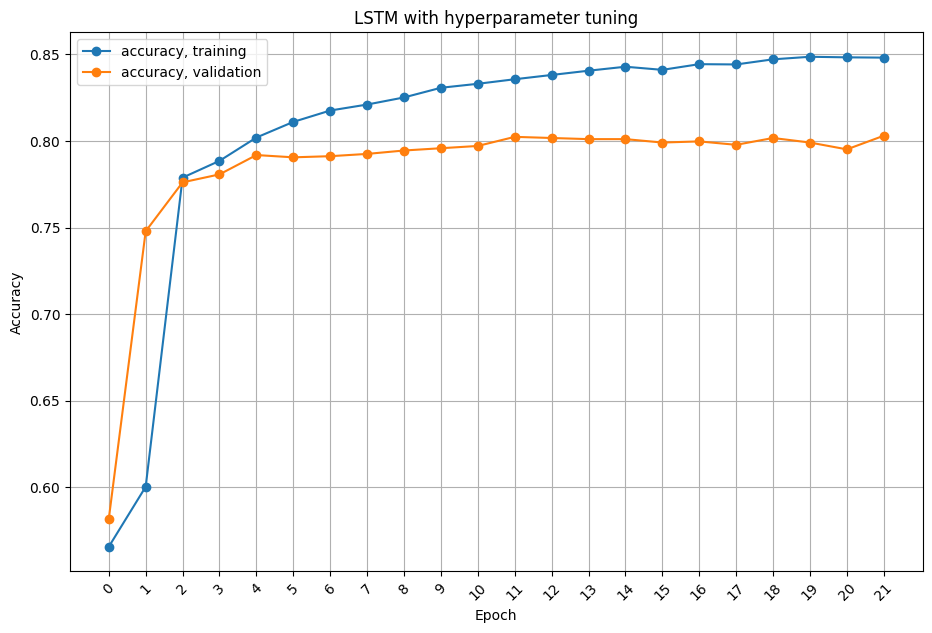

In [51]:
plot_accuracy(history, "LSTM with hyperparameter tuning")

In [52]:
# save submission
y_test_pred = model.predict(padded_sequences_test)

102/102 [==============================] - 1s 7ms/step


In [53]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = (y_test_pred > 0.5).astype(int)

submission_df.to_csv("./submissions/LSTM_with_tuning.csv", index=False)

### Fine-Tuning Pretrained BERT

In [54]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [55]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'], 
    train_df['target'],
    test_size=0.2,
    random_state=0
)

In [56]:
# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize the training and validation texts
train_encodings = tokenizer(
    list(train_texts),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf' 
)

val_encodings = tokenizer(
    list(val_texts),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_encodings = tokenizer(
    list(test_df['text']),
    max_length=50,
    padding='max_length',
    truncation=True,
    return_tensors='tf' 
)

In [57]:
# convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels.tolist())
val_labels = tf.convert_to_tensor(val_labels.tolist())

# create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    val_labels
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}
)).batch(32)

In [67]:
# load and compile BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6,epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_229 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
191/191 [==============================] - 73s 225ms/step - loss: 0.6252 - accuracy: 0.6391 - val_loss: 0.5348 - val_accuracy: 0.7827
Epoch 2/100
191/191 [==============================] - 38s 201ms/step - loss: 0.4926 - accuracy: 0.7951 - val_loss: 0.4526 - val_accuracy: 0.8194
Epoch 3/100
191/191 [==============================] - 38s 198ms/step - loss: 0.4266 - accuracy: 0.8279 - val_loss: 0.4219 - val_accuracy: 0.8359
Epoch 4/100
191/191 [==============================] - 38s 200ms/step - loss: 0.3892 - accuracy: 0.8452 - val_loss: 0.4165 - val_accuracy: 0.8365
Epoch 5/100
191/191 [==============================] - 38s 196ms/step - loss: 0.3597 - accuracy: 0.8617 - val_loss: 0.4003 - val_accuracy: 0.8385
Epoch 6/100
191/191 [==============================] - 38s 197ms/step - loss: 0.3370 - accuracy: 0.8736 - val_loss: 0.4068 - val_accuracy: 0.8404
Epoch 7/100
191/191 [==============================] - 37s 195ms/step - loss: 0.3209 - accuracy: 0.8819 - val_loss: 0.4106 -

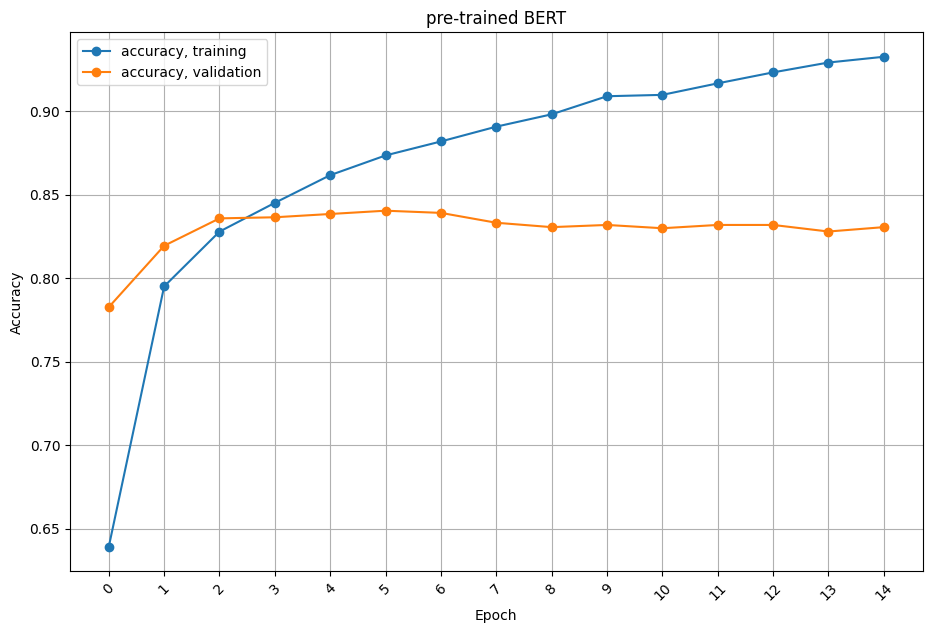

In [69]:
plot_accuracy(history, "pre-trained BERT")

In [70]:
predictions = model.predict(test_dataset)
probabilities = tf.nn.sigmoid(predictions.logits)
predicted_classes = tf.cast(probabilities > 0.5, dtype=tf.int32)

102/102 [==============================] - 11s 84ms/step


In [71]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['target'] = np.array(predicted_classes)

submission_df.to_csv("./submissions/BERT.csv", index=False)